### Artificial Neural Network for the Prediction of Specific Heat Capacity using a Stacked Model approach and  Molecular Weight with Acentric Factor

In [1]:
# Numpy (manipulation of arrays)
import numpy as np
# Pandas (manipulation of databases)
import pandas as pd
# Matplotlib (plotting library)
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Import scikit learn classifier and regressor.
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

# Import the random forest regressor
from sklearn.ensemble import RandomForestRegressor

# Import Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

#Import Support Vector Regressor
from sklearn.svm import SVR

# Tool for splitting sets. Needed to split training and test data
from sklearn.model_selection import train_test_split
# Tool for splitting sets. Used to apply kFold validation on the data sets
from sklearn.model_selection import KFold 

# Module to normalized data
from sklearn import preprocessing
# Module to standardise data
from sklearn.preprocessing import StandardScaler

# Tool for calculation of the mean square error (mse) and mean absolut error (mae)
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tool for calculating R2 score
from sklearn.metrics import r2_score 

In [2]:
# Dictates which columns I would like to read from the databse
columns = ['Temperature (K)','Density (kg/m3)','Cp (J/g*K)','Molecular Weight', 'Acentric factor']

# Read data base, specifies no specific sheet thus reads all of them together
d = pd.read_excel('databaseaf.xlsx', sheet_name=None, header=0, usecols=columns)

# Colates the multiple sheets in the data base
df = pd.concat(d.values(), ignore_index=True)

# Print data base 
df

,Temperature (K),Density (kg/m3),Cp (J/g*K),Acentric factor,Molecular Weight
0,100,438.94,3.4079,0.01142,16
1,100,439.01,3.4071,0.01142,16
2,100,439.09,3.4064,0.01142,16
3,100,439.16,3.4056,0.01142,16
4,100,439.24,3.4048,0.01142,16
...,...,...,...,...,...
32188,550,103.68,2.7645,0.14600,42
32189,550,104.89,2.7686,0.14600,42
32190,550,106.10,2.7728,0.14600,42
32191,550,107.31,2.7769,0.14600,42


In [3]:
# Describe the database (means, standard deviations, etc.)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature (K),32193.0,385.517814,144.592856,100.00000,275.0000,375.0000,500.0000,725.000
Density (kg/m3),32193.0,423.350630,270.333971,0.30866,93.7630,515.7600,649.4900,885.900
Cp (J/g*K),32193.0,2.804666,0.992241,1.28990,2.2575,2.6711,3.1393,34.187
Acentric factor,32193.0,0.268565,0.159493,0.01142,0.1521,0.2274,0.3980,0.574
Molecular Weight,32193.0,73.864380,41.650803,16.00000,42.0000,72.0000,100.0000,170.000


In [4]:
# Identify target column (output). For this example, wine quality is the target property
target = ['Cp (J/g*K)']

#Prints target
target

['Cp (J/g*K)']

In [5]:
# Specifies exact features (inputs) in order
features = ['Temperature (K)','Density (kg/m3)','Molecular Weight', 'Acentric factor']

#Prints features
features

['Temperature (K)', 'Density (kg/m3)', 'Molecular Weight', 'Acentric factor']

In [6]:
# Extract input (feature) data and output (target) data from database 
x_data = df[features].values
y_data = df[target].values

# Split data for training and testing. In this example, the splits is 75:25
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.25,random_state=40,shuffle=True)

print(x_train.shape)
print(x_test.shape)

(24144, 4)
(8049, 4)


In [7]:
# Define the data scaler
scaler = StandardScaler()

# Fits and transforms x_train data set (standardisation)
x_train_scaled = scaler.fit_transform(x_train)

# Transforms x_test data set using the mean and standard deviation from the fitted x_train data set
x_test_scaled = scaler.transform(x_test)

# Create a Gradient Boosting regressor
GBR = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.01,max_depth=15,random_state=0,loss='squared_error')
GBR.fit(x_train_scaled, y_train.ravel())
GBR_preds = GBR.predict(x_test_scaled)

# Create an Artificial Neural Network architecture 
MLP = MLPRegressor(hidden_layer_sizes=(30,10,4),solver='lbfgs',alpha=1e-5,random_state=1,max_iter=50000)
MLP.fit(x_train_scaled, y_train.ravel())
MLP_preds = MLP.predict(x_test_scaled)

# Create a Support Vector regressor
SVR = SVR(kernel='rbf', C=200, gamma=15, epsilon=0.01)
SVR.fit(x_train_scaled, y_train.ravel())
SVR_preds = SVR.predict(x_test_scaled)

# Stack the predictions
stacked_features = np.column_stack((GBR_preds, MLP_preds, SVR_preds))

# Train a meta-model on the stacked features
clf = RandomForestRegressor(n_estimators=200,max_depth=10,random_state=1)
clf.fit(stacked_features, y_test.ravel())

# Calculates the R2 score after fitting
r2_test = clf.score(stacked_features, y_test)
print('The R2 for the test data after fitting is: {0:6.5f}'.format(r2_test).rstrip('0'))

The R2 for the test data after fitting is: 0.99763


In [8]:
# Use the optimized neural network to predict the output
predict_train_set1 = GBR.predict(x_train_scaled)
predict_train_set2 = MLP.predict(x_train_scaled)
predict_train_set3 = SVR.predict(x_train_scaled)
predict_test_set = clf.predict(stacked_features)
#predict_val_set = clf.predict(stacked_val_features)

# Calculates the mean squared error
mse = mean_squared_error(y_test, predict_test_set)
mse_rounded = round(mse, 5)
print(f"Mean squared error: {mse_rounded}")

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, predict_test_set)
mae_rounded = round(mae, 5)
print(f"Mean absolute error: {mae_rounded}")

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(y_test, predict_test_set, squared=False)
rmse_rounded = round(rmse, 5)
print(f"Root mean squared error: {rmse_rounded}")

# Calculate average absolute deviation (AAD)
summation = 0
n = len(y_test)
for i in range(0,n):
    difference = predict_test_set[i]-y_test[i]
    frac = difference/y_test[i]
    squared = frac**2
    summation = summation + squared
    aad = (summation/n)[0]
    aad_rounded = str(np.round(aad, 5)).rstrip('0').rstrip('.')
print(f"Average absolute deviation: {aad_rounded}")

Mean squared error: 0.00251
Mean absolute error: 0.00536
Root mean squared error: 0.05014
Average absolute deviation: 3e-05


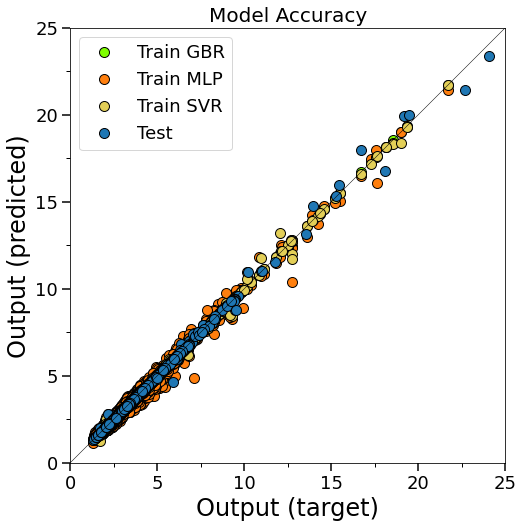

In [9]:
# Plots a graph comparing the the accuracy of the train and test data sets
plt.figure(figsize=(8, 8))

ax1 = plt.subplot(1, 1, 1)

ax1.plot(y_train, predict_train_set1, marker='o', ls='None', mec='k', mfc='#7FFF00', label='Train GBR', markersize=10)
ax1.plot(y_train, predict_train_set2, marker='o', ls='None', mec='k', mfc='#FF7F0E', label='Train MLP', markersize=10)
ax1.plot(y_train, predict_train_set3, marker='o', ls='None', mec='k', mfc='#E3CF57', label='Train SVR', markersize=10)
#ax1.plot(y_val, predict_val_set, marker='o', ls='None', mec='k', mfc='#FFC0CB', label='Validation', markersize=10)
ax1.plot(y_test, predict_test_set, marker='o', ls='None', mec='k', mfc='#1F77B4', label='Test', markersize=10)
ax1.legend(fontsize=18)

ax1.plot([0,26],[0,26],'-k',lw=0.5)

ax1.tick_params(axis='both',which='major',labelsize=18,length=8,width=1.5,pad=4,direction='out')
ax1.tick_params(axis='both',which='minor',labelsize=18,length=4,width=1,pad=4,direction='out')

ax1.set_xlim([0,25])
ax1.set_ylim([0,25])
ax1.set_xlabel('Output (target)',fontsize=24)
ax1.set_ylabel('Output (predicted)',fontsize=24)
ax1.set_title('Model Accuracy', fontsize=20)

majorLocator = MultipleLocator(5)
minorLocator = MultipleLocator(2.5)
ax1.xaxis.set_major_locator(majorLocator)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.yaxis.set_major_locator(majorLocator)
ax1.yaxis.set_minor_locator(minorLocator)

#ax1.grid(True)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [10]:
### Loop until the user chooses to exit
while True:
    # Ask the user for input values
    temperature = float(input("Enter Temperature (K): "))
    density = float(input("Enter Density (kg/m3): "))
    molecular_weight = float(input("Enter Molecular Weight: "))
    acentric_factor = float(input("Enter Acentric Factor: "))

    # Create a numpy array from the input values and reshape
    input_values = np.array([temperature, density, molecular_weight, acentric_factor]).reshape(1, -1)

    # Scale the input values to match the training and test data
    scaled_input = scaler.transform(input_values)
    
    # Use the meta-model to make predictions on new data
    GBR_pred = GBR.predict(scaled_input)
    MLP_pred = MLP.predict(scaled_input)
    SVR_pred = SVR.predict(scaled_input)
    
    # Combine the individual models' predictions with the original input features
    stacked_features = np.column_stack((GBR_pred, MLP_pred, SVR_pred))
    
    # Use the trained meta-model to make predictions on the stacked features
    predicted_cp = clf.predict(stacked_features)[0]
    
    # Round the predicted value to 4 decimal places and remove trailing zeros
    predicted_cp_rounded = str(np.round(predicted_cp, 4)).rstrip('0').rstrip('.')

    # Print the predicted and actual Cp values
    print(f"Predicted Cp: {predicted_cp_rounded}")

    # Ask the user if they want to enter new input values or exit
    choice = input("Do you want to enter new input values? (Y/N) ").upper()
    if choice != "Y":
        break

Enter Temperature (K): 150
Enter Density (kg/m3): 757.97
Enter Molecular Weight: 72
Enter Acentric Factor: 0.251
Predicted Cp: 1.9621
Do you want to enter new input values? (Y/N) n
